# Semantic Segmentation of Flood Events using U-Net for Real-Time Flood Hazard Assessment(Google Girl's Hackathon Project)
1. Submitted by-Swastika Satya
2. GOC ID - 954790390322

# A.Import

In [1]:
# Common
import os
import cv2 as cv
from keras.metrics import MeanIoU
from tqdm import tqdm

# data 
import numpy as np 
from keras.preprocessing.image import load_img, img_to_array

# viz
import matplotlib.pyplot as plt

# Model
import keras 
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras import Sequential 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **B.Data**

In [2]:
def show_image(image, cmap=None, title=None):
  plt.imshow(image, cmap=cmap)
  if title is not None: plt.title(title)
  plt.axis('off')


In [3]:
images = []
mask = []

image_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/'
mask_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
  print('Image and Mask are corretly Placed!!')

Image and Mask are corretly Placed!!


In [4]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = img_to_array(load_img(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = img_to_array(load_img(path)).astype('float')/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [01:00<00:00, 47.07it/s] 


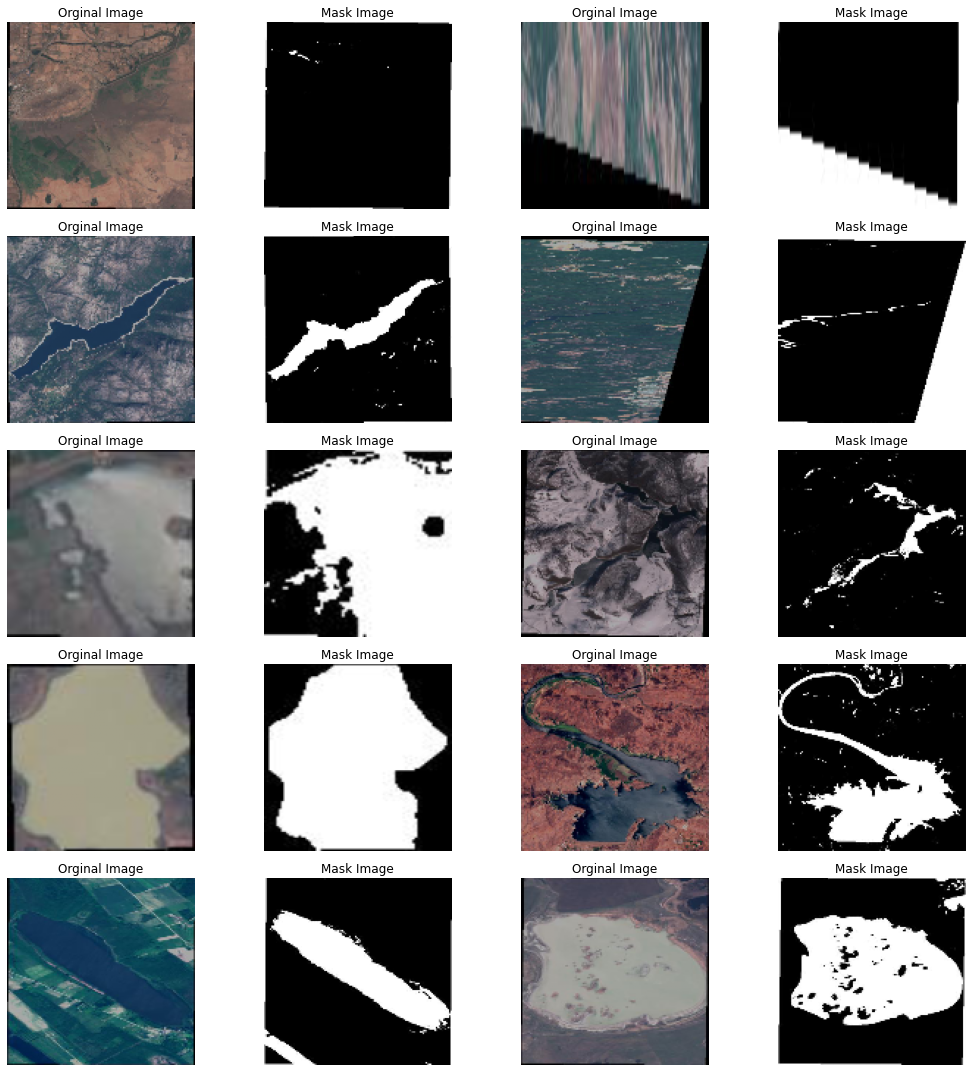

In [5]:
plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    show_image(images[id], title="Orginal Image")
  elif i%2==0:
    show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')

plt.tight_layout()
plt.show()

# **C.Model-U-Net**

In [6]:
X, y = images[:int(len(images)*0.9)], masks[:int(len(images)*0.9)]
test_X, test_y = images[int(len(images)*0.9):], masks[int(len(images)*0.9):]

# Encoder

In [7]:
# Contraction 
class EncoderBlock(keras.layers.Layer):
  
  def __init__(self, filters, rate=None, pooling=True):
    super(EncoderBlock,self).__init__()
    self.filters = filters
    self.rate = rate
    self.pooling = pooling
    self.conv1 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
    self.conv2 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
    if self.pooling: self.pool = MaxPool2D(pool_size=(2,2))
    if self.rate is not None: self.drop = Dropout(rate)
    
  def call(self, inputs):
    x = self.conv1(inputs)
    if self.rate is not None: x = self.drop(x)
    x = self.conv2(x)
    if self.pooling: 
      y = self.pool(x)
      return y, x
    else:
      return x
  
  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config, 
        "filters":self.filters,
        "rate":self.rate,
        "pooling":self.pooling
    }


# Decoder

In [8]:
# Expansion
class DecoderBlock(keras.layers.Layer):
  
  def __init__(self, filters, rate=None, axis=-1):
    super(DecoderBlock,self).__init__()
    self.filters = filters
    self.rate = rate
    self.axis = axis
    self.convT = Conv2DTranspose(self.filters,kernel_size=3,strides=2,padding='same')
    self.conv1 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
    if rate is not None: self.drop = Dropout(self.rate)
    self.conv2 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
    
  def call(self, inputs):
    X, short_X = inputs
    ct = self.convT(X)
    c_ = concatenate([ct, short_X], axis=self.axis)
    x = self.conv1(c_)
    if self.rate is not None: x = self.drop(x)
    y = self.conv2(x)
    return y
  
  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config, 
        "filters":self.filters,
        "rate":self.rate,
        "axis":self.axis,
    }


In [9]:
# Callback 
class ShowProgress(keras.callbacks.Callback):
  def __init__(self, save=False):
    self.save = save
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask)
    proc_mask2 = post_process(pred_mask, threshold=0.5)
    proc_mask3 = post_process(pred_mask, threshold=0.9)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(10,5))

    plt.subplot(1,6,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,6,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')
    
    plt.subplot(1,6,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,6,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,6,5)
    show_image(proc_mask2, title="Processed@0.5", cmap='gray')

    plt.subplot(1,6,6)
    show_image(proc_mask3, title="Processed@0.9", cmap='gray')

    plt.tight_layout()
    if self.save: plt.savefig("Progress-{}.png".format(epoch+1))
    plt.show()


In [10]:
# Post Process
def post_process(image,threshold=0.4):
  return image>threshold

In [11]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction 
p1, c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4) 

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1, axis=3)([d3,c1])

# Outputs 
outputs = Conv2D(1,1,activation='sigmoid')(d4)

unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

# Adam Optimizer

In [12]:
unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [13]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('UNet-01.h5',save_best_only=True),
    ShowProgress(save=True)
]

In [14]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_block (EncoderBlock)    ((None, 64, 64, 16), 2768        input_1[0][0]                    
__________________________________________________________________________________________________
encoder_block_1 (EncoderBlock)  ((None, 32, 32, 32), 13888       encoder_block[0][0]              
__________________________________________________________________________________________________
encoder_block_2 (EncoderBlock)  ((None, 16, 16, 64), 55424       encoder_block_1[0][0]            
______________________________________________________________________________________________

Epoch 1/100
144/144 [==============================] - 139s 947ms/step - loss: 0.5287 - accuracy: 0.6080 - val_loss: 0.4777 - val_accuracy: 0.6092


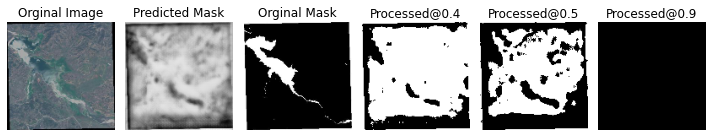

Epoch 2/100
144/144 [==============================] - 136s 942ms/step - loss: 0.4840 - accuracy: 0.6405 - val_loss: 0.4536 - val_accuracy: 0.6466


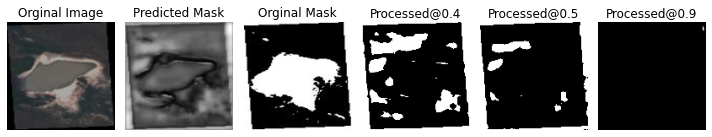

Epoch 3/100
144/144 [==============================] - 135s 937ms/step - loss: 0.4435 - accuracy: 0.6589 - val_loss: 0.5331 - val_accuracy: 0.5915


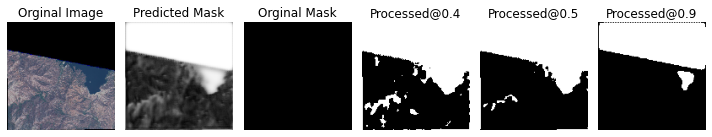

Epoch 4/100
144/144 [==============================] - 134s 934ms/step - loss: 0.4272 - accuracy: 0.6669 - val_loss: 0.3737 - val_accuracy: 0.6969


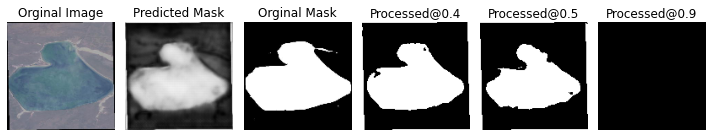

Epoch 5/100
144/144 [==============================] - 135s 934ms/step - loss: 0.4064 - accuracy: 0.6757 - val_loss: 0.3302 - val_accuracy: 0.6972


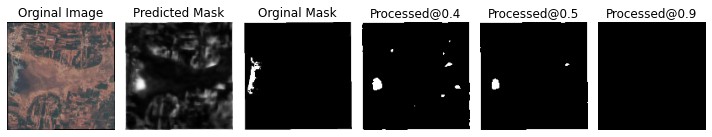

Epoch 6/100
144/144 [==============================] - 134s 931ms/step - loss: 0.3779 - accuracy: 0.6871 - val_loss: 0.3125 - val_accuracy: 0.7115


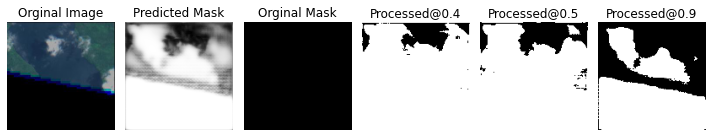

Epoch 7/100
144/144 [==============================] - 133s 924ms/step - loss: 0.3571 - accuracy: 0.6960 - val_loss: 0.3789 - val_accuracy: 0.6680


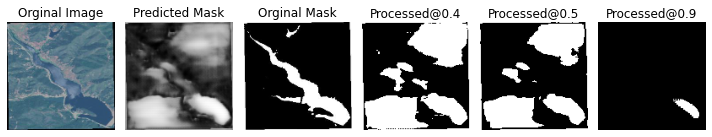

Epoch 8/100
144/144 [==============================] - 134s 928ms/step - loss: 0.3522 - accuracy: 0.7015 - val_loss: 0.3076 - val_accuracy: 0.7106


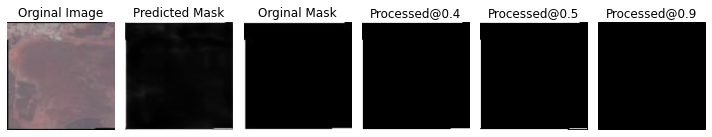

Epoch 9/100
144/144 [==============================] - 134s 934ms/step - loss: 0.3378 - accuracy: 0.7054 - val_loss: 0.2747 - val_accuracy: 0.7244


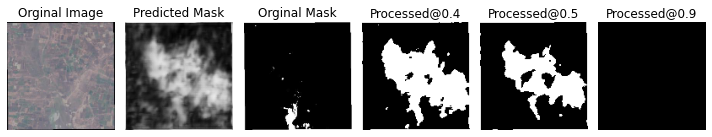

Epoch 10/100
144/144 [==============================] - 134s 931ms/step - loss: 0.3395 - accuracy: 0.7081 - val_loss: 0.2807 - val_accuracy: 0.7214


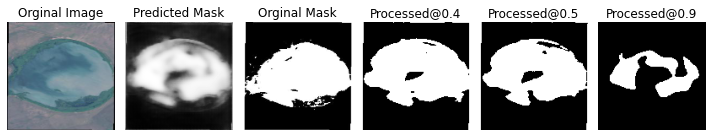

Epoch 11/100
144/144 [==============================] - 134s 928ms/step - loss: 0.3277 - accuracy: 0.7093 - val_loss: 0.2730 - val_accuracy: 0.7276


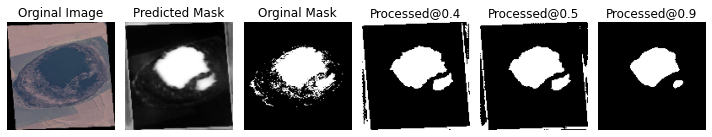

Epoch 12/100
144/144 [==============================] - 133s 926ms/step - loss: 0.3285 - accuracy: 0.7121 - val_loss: 0.3041 - val_accuracy: 0.7080


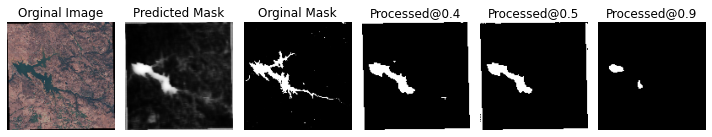

Epoch 13/100
144/144 [==============================] - 133s 926ms/step - loss: 0.3155 - accuracy: 0.7143 - val_loss: 0.2537 - val_accuracy: 0.7335


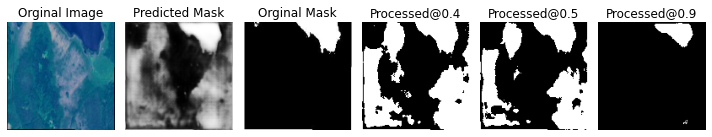

Epoch 14/100
144/144 [==============================] - 134s 932ms/step - loss: 0.2938 - accuracy: 0.7242 - val_loss: 0.2568 - val_accuracy: 0.7294


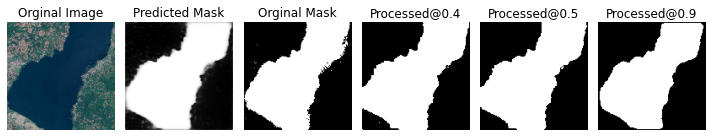

Epoch 15/100
144/144 [==============================] - 134s 930ms/step - loss: 0.2896 - accuracy: 0.7273 - val_loss: 0.2571 - val_accuracy: 0.7286


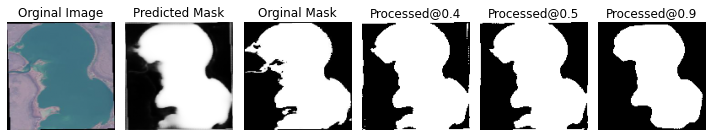

Epoch 16/100
144/144 [==============================] - 133s 923ms/step - loss: 0.2785 - accuracy: 0.7299 - val_loss: 0.2436 - val_accuracy: 0.7322


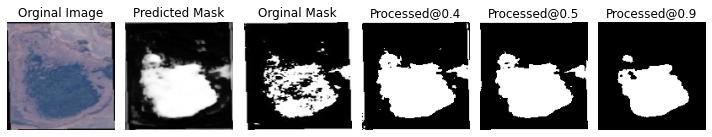

Epoch 17/100
144/144 [==============================] - 134s 928ms/step - loss: 0.2750 - accuracy: 0.7309 - val_loss: 0.2580 - val_accuracy: 0.7319


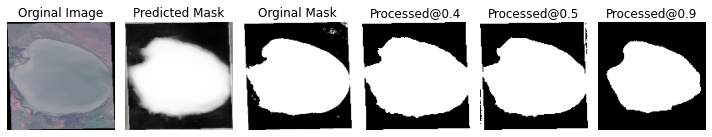

Epoch 18/100
144/144 [==============================] - 134s 932ms/step - loss: 0.2655 - accuracy: 0.7361 - val_loss: 0.2614 - val_accuracy: 0.7268


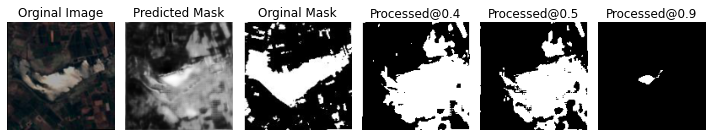

Epoch 19/100
144/144 [==============================] - 133s 927ms/step - loss: 0.2696 - accuracy: 0.7339 - val_loss: 0.2357 - val_accuracy: 0.7378


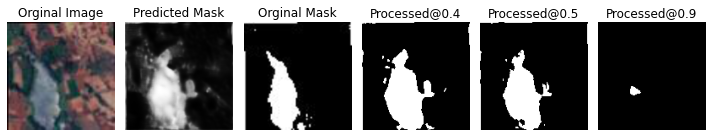

Epoch 20/100
144/144 [==============================] - 135s 938ms/step - loss: 0.2575 - accuracy: 0.7373 - val_loss: 0.2266 - val_accuracy: 0.7406


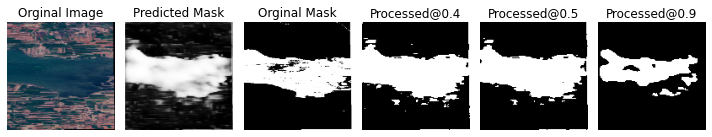

Epoch 21/100
144/144 [==============================] - 134s 929ms/step - loss: 0.2588 - accuracy: 0.7376 - val_loss: 0.2624 - val_accuracy: 0.7289


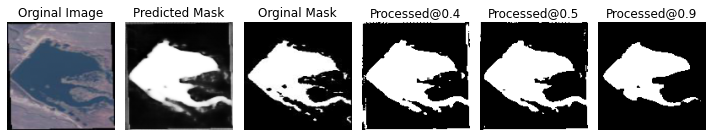

Epoch 22/100
144/144 [==============================] - 135s 941ms/step - loss: 0.2539 - accuracy: 0.7393 - val_loss: 0.2258 - val_accuracy: 0.7395


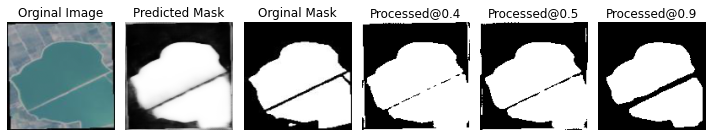

Epoch 23/100
144/144 [==============================] - 135s 939ms/step - loss: 0.2494 - accuracy: 0.7405 - val_loss: 0.2275 - val_accuracy: 0.7404


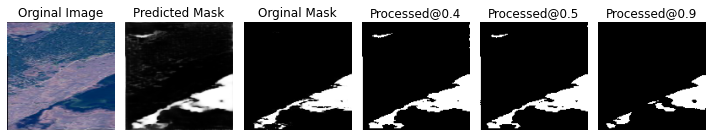

Epoch 24/100
144/144 [==============================] - 136s 947ms/step - loss: 0.2451 - accuracy: 0.7418 - val_loss: 0.2340 - val_accuracy: 0.7409


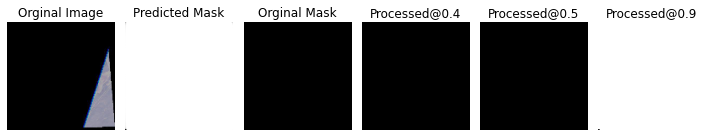

Epoch 25/100
144/144 [==============================] - 136s 947ms/step - loss: 0.2451 - accuracy: 0.7425 - val_loss: 0.2221 - val_accuracy: 0.7436


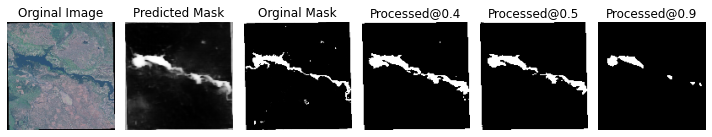

Epoch 26/100
144/144 [==============================] - 134s 933ms/step - loss: 0.2400 - accuracy: 0.7444 - val_loss: 0.2220 - val_accuracy: 0.7415


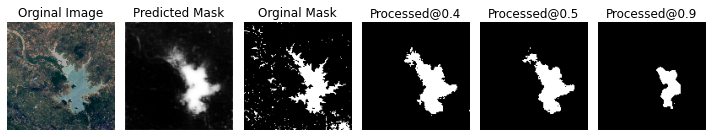

Epoch 27/100
144/144 [==============================] - 134s 933ms/step - loss: 0.2427 - accuracy: 0.7438 - val_loss: 0.2246 - val_accuracy: 0.7414


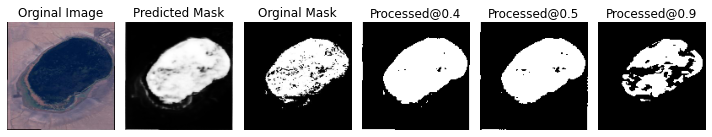

Epoch 28/100
144/144 [==============================] - 134s 933ms/step - loss: 0.2418 - accuracy: 0.7439 - val_loss: 0.2212 - val_accuracy: 0.7423


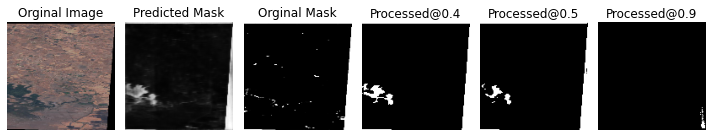

Epoch 29/100
144/144 [==============================] - 135s 940ms/step - loss: 0.2370 - accuracy: 0.7452 - val_loss: 0.2207 - val_accuracy: 0.7431


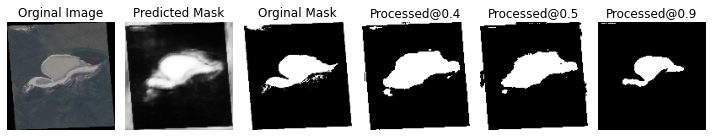

Epoch 30/100
144/144 [==============================] - 135s 940ms/step - loss: 0.2891 - accuracy: 0.7280 - val_loss: 0.2431 - val_accuracy: 0.7343


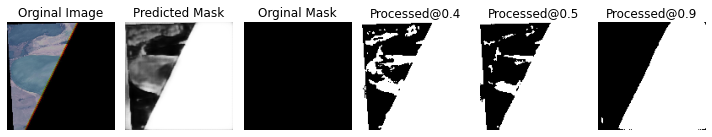

Epoch 31/100
144/144 [==============================] - 136s 943ms/step - loss: 0.2640 - accuracy: 0.7352 - val_loss: 0.2428 - val_accuracy: 0.7343


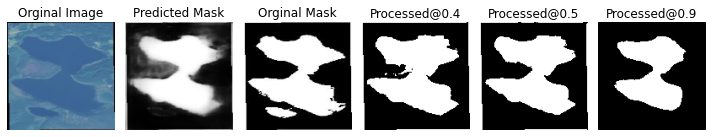

Epoch 32/100
144/144 [==============================] - 137s 953ms/step - loss: 0.2570 - accuracy: 0.7368 - val_loss: 0.2203 - val_accuracy: 0.7430


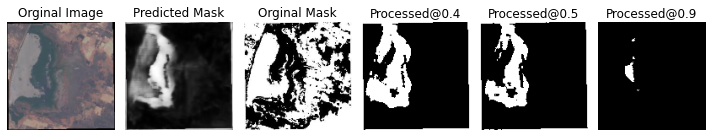

Epoch 33/100
144/144 [==============================] - 135s 938ms/step - loss: 0.2338 - accuracy: 0.7456 - val_loss: 0.2285 - val_accuracy: 0.7413


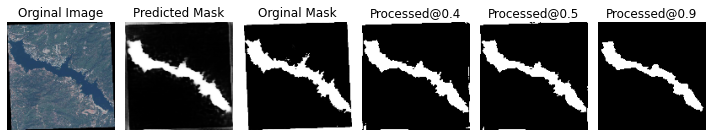

Epoch 34/100
144/144 [==============================] - 136s 943ms/step - loss: 0.2250 - accuracy: 0.7488 - val_loss: 0.2175 - val_accuracy: 0.7424


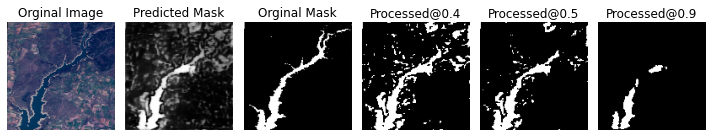

Epoch 35/100
144/144 [==============================] - 136s 948ms/step - loss: 0.2297 - accuracy: 0.7469 - val_loss: 0.2208 - val_accuracy: 0.7430


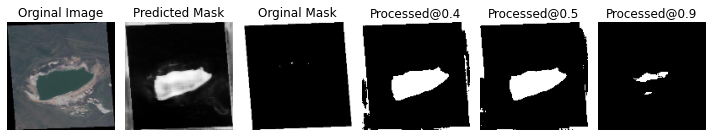

Epoch 36/100
144/144 [==============================] - 136s 943ms/step - loss: 0.2273 - accuracy: 0.7477 - val_loss: 0.2187 - val_accuracy: 0.7446


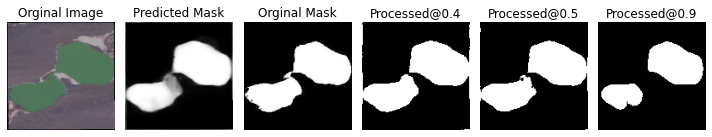

Epoch 37/100
144/144 [==============================] - 134s 932ms/step - loss: 0.2122 - accuracy: 0.7531 - val_loss: 0.2126 - val_accuracy: 0.7454


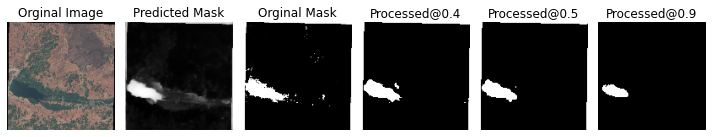

Epoch 38/100
144/144 [==============================] - 135s 936ms/step - loss: 0.2188 - accuracy: 0.7504 - val_loss: 0.2163 - val_accuracy: 0.7427


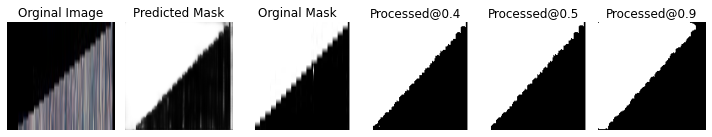

Epoch 39/100
144/144 [==============================] - 135s 936ms/step - loss: 0.2074 - accuracy: 0.7545 - val_loss: 0.2323 - val_accuracy: 0.7390


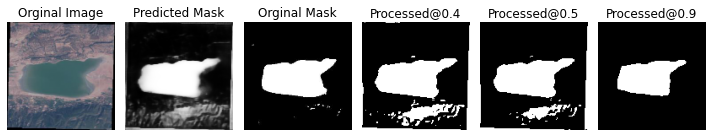

Epoch 40/100
144/144 [==============================] - 135s 941ms/step - loss: 0.2150 - accuracy: 0.7517 - val_loss: 0.2270 - val_accuracy: 0.7424


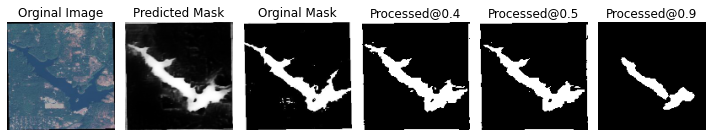

CPU times: user 5h 27min 33s, sys: 2min 11s, total: 5h 29min 44s
Wall time: 1h 30min 19s


In [15]:
%%time
with tf.device("/GPU:0"):
  results = unet.fit(
      X, y,
      epochs=100,
      callbacks=callbacks,
      validation_split=0.1,
      batch_size=16
  )

* After looking at the produced images, it could be said that the model is actually able to identify the regions of water but its confused between water and forest when the color difference between them is low.

* It could also be noticed that the model is actually preserving some of these spatial features which we actually don't want in the final image. That's why I have post processed it.

* Overall, the model is great. It's actually able to identify the regions correctly. Well, not exactly up to the point, but roughly correct enough to be convincing.

# **D.Adaptive Threshold UNET**

In [16]:
# Callback 
class ShowProgress(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask, threshold=0.5)
    thresh = float(np.mean(pred_mask) + np.min(pred_mask))
    proc_mask2 = post_process(pred_mask, threshold=thresh)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(15,6))

    plt.subplot(1,5,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,5,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')
    
    plt.subplot(1,5,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,5,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,5,5)
    show_image(proc_mask2, title="Processed@{:.2}".format(thresh), cmap='gray')

    plt.tight_layout()
    plt.show()

# Post Process
def post_process(image,threshold): return image>threshold

In [17]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction 
p1, c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4) 

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1, axis=3)([d3,c1])

# Outputs
outputs = Conv2D(1,1,activation='sigmoid')(d4)

unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

In [18]:
unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [19]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('Adaptive-UNet.h5',save_best_only=True),
    ShowProgress()
]

Epoch 1/100
72/72 [==============================] - 133s 2s/step - loss: 0.5528 - accuracy: 0.5765 - val_loss: 0.5779 - val_accuracy: 0.5122


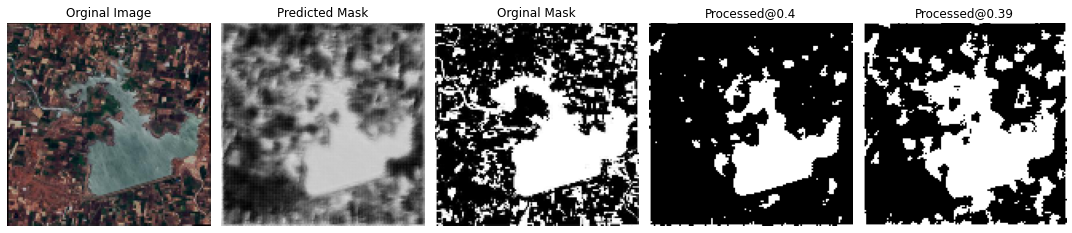

Epoch 2/100
72/72 [==============================] - 130s 2s/step - loss: 0.4973 - accuracy: 0.6248 - val_loss: 0.4924 - val_accuracy: 0.5777


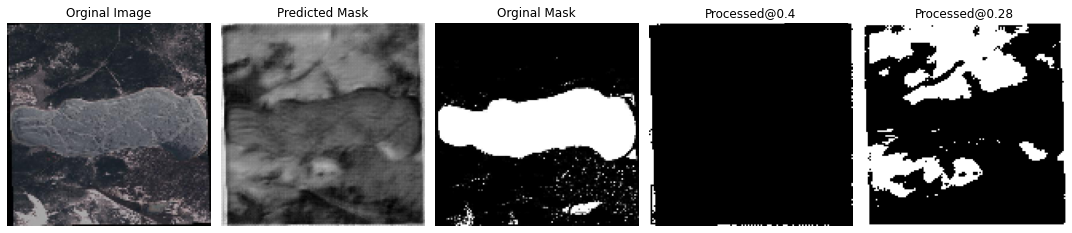

Epoch 3/100
72/72 [==============================] - 131s 2s/step - loss: 0.4721 - accuracy: 0.6376 - val_loss: 0.5211 - val_accuracy: 0.5965


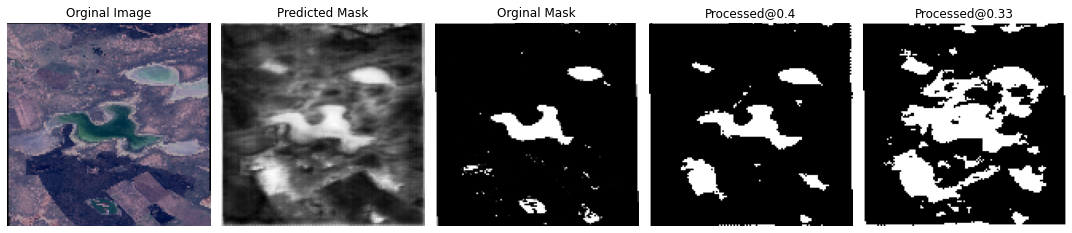

Epoch 4/100
72/72 [==============================] - 131s 2s/step - loss: 0.4753 - accuracy: 0.6392 - val_loss: 0.4596 - val_accuracy: 0.6188


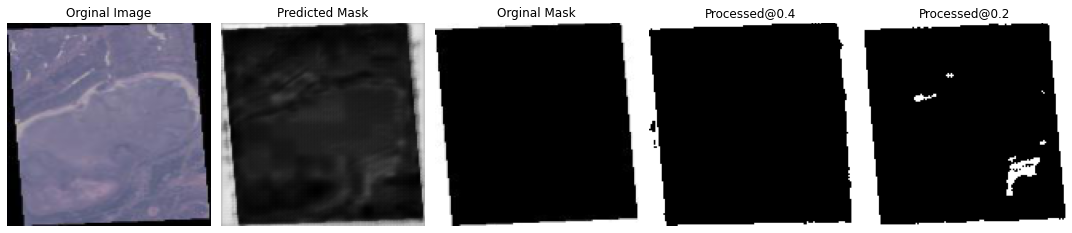

Epoch 5/100
72/72 [==============================] - 132s 2s/step - loss: 0.4380 - accuracy: 0.6590 - val_loss: 0.4570 - val_accuracy: 0.6404


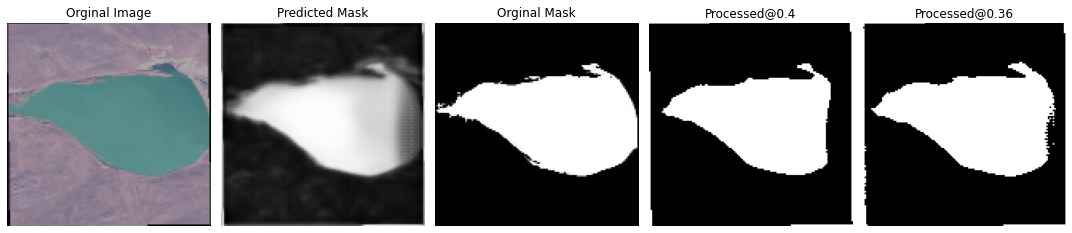

Epoch 6/100
72/72 [==============================] - 132s 2s/step - loss: 0.4223 - accuracy: 0.6702 - val_loss: 0.4525 - val_accuracy: 0.6352


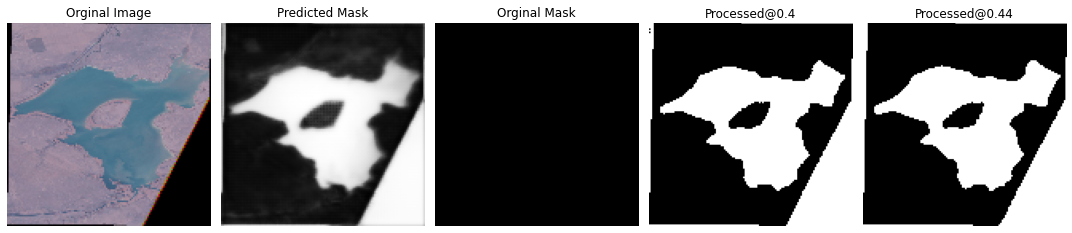

Epoch 7/100
72/72 [==============================] - 132s 2s/step - loss: 0.4109 - accuracy: 0.6763 - val_loss: 0.3941 - val_accuracy: 0.6733


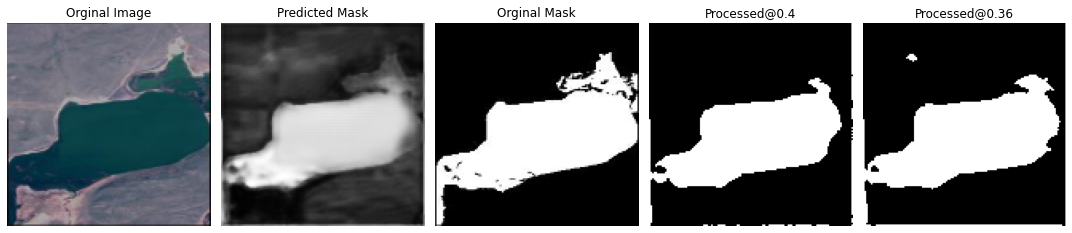

Epoch 8/100
72/72 [==============================] - 131s 2s/step - loss: 0.3937 - accuracy: 0.6856 - val_loss: 0.4031 - val_accuracy: 0.6672


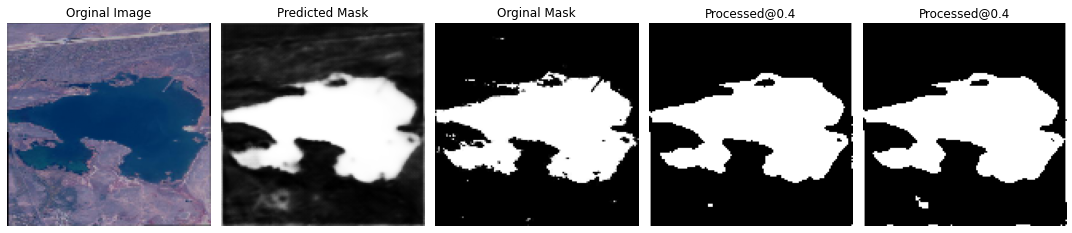

Epoch 9/100
72/72 [==============================] - 131s 2s/step - loss: 0.3690 - accuracy: 0.6963 - val_loss: 0.3259 - val_accuracy: 0.7072


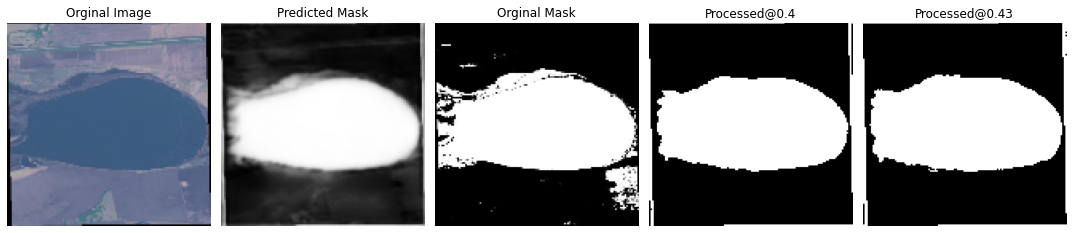

Epoch 10/100
72/72 [==============================] - 130s 2s/step - loss: 0.3609 - accuracy: 0.7000 - val_loss: 0.3149 - val_accuracy: 0.7141


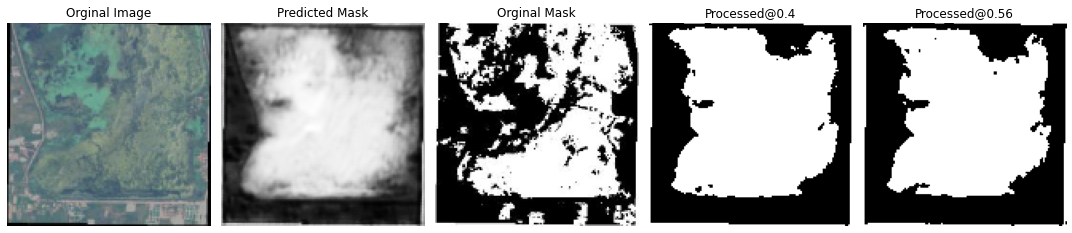

Epoch 11/100
72/72 [==============================] - 130s 2s/step - loss: 0.3479 - accuracy: 0.7049 - val_loss: 0.3018 - val_accuracy: 0.7160


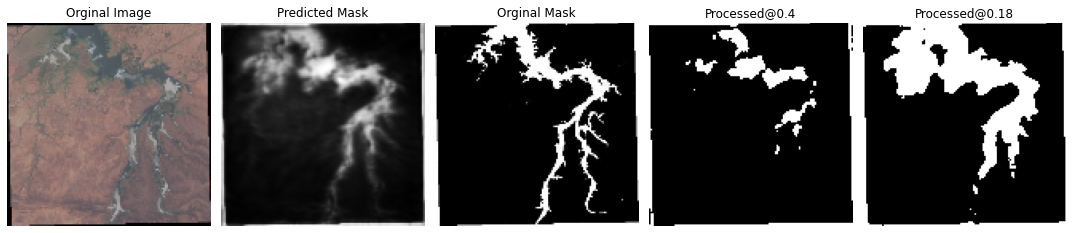

Epoch 12/100
72/72 [==============================] - 130s 2s/step - loss: 0.3292 - accuracy: 0.7122 - val_loss: 0.2946 - val_accuracy: 0.7219


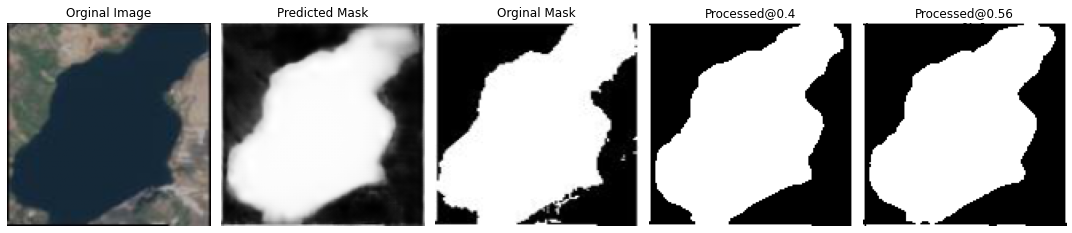

Epoch 13/100
72/72 [==============================] - 130s 2s/step - loss: 0.3289 - accuracy: 0.7124 - val_loss: 0.3131 - val_accuracy: 0.7100


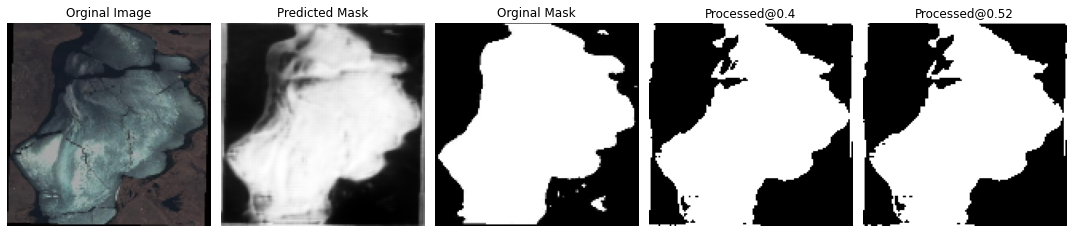

Epoch 14/100
72/72 [==============================] - 131s 2s/step - loss: 0.3272 - accuracy: 0.7152 - val_loss: 0.3146 - val_accuracy: 0.7157


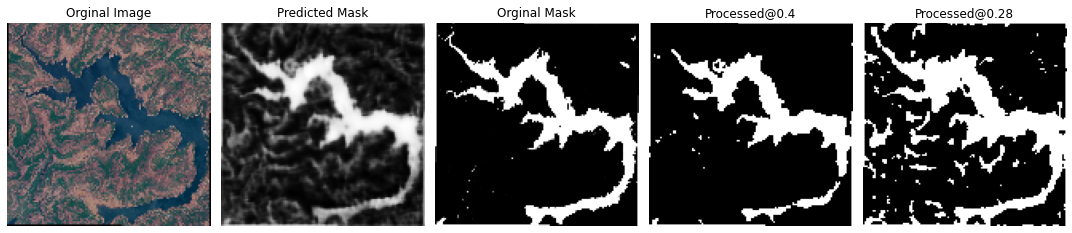

Epoch 15/100
72/72 [==============================] - 131s 2s/step - loss: 0.3066 - accuracy: 0.7229 - val_loss: 0.2912 - val_accuracy: 0.7191


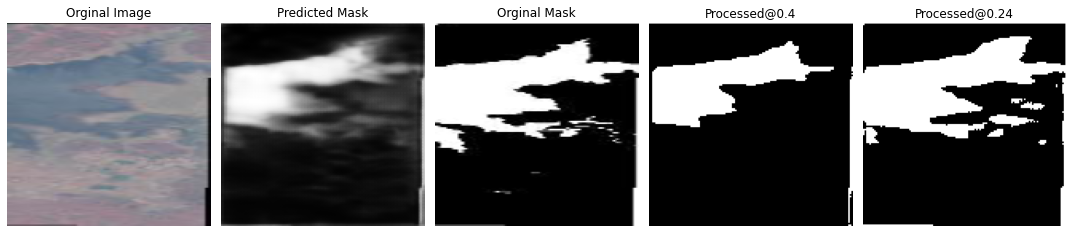

Epoch 16/100
72/72 [==============================] - 132s 2s/step - loss: 0.3023 - accuracy: 0.7240 - val_loss: 0.2667 - val_accuracy: 0.7295


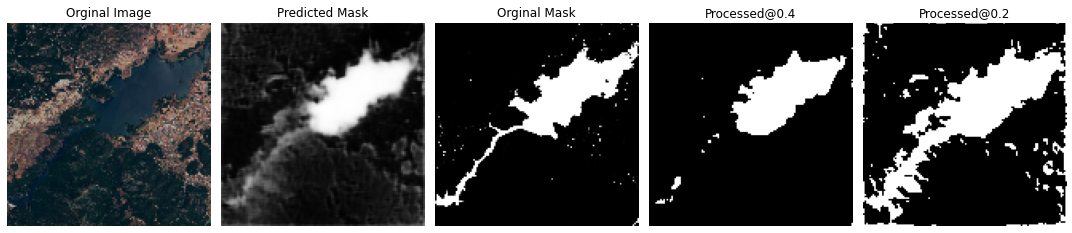

Epoch 17/100
72/72 [==============================] - 132s 2s/step - loss: 0.2991 - accuracy: 0.7253 - val_loss: 0.2602 - val_accuracy: 0.7315


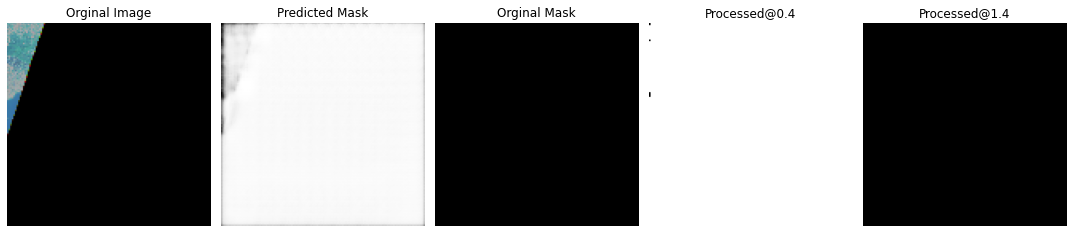

Epoch 18/100
72/72 [==============================] - 131s 2s/step - loss: 0.2963 - accuracy: 0.7264 - val_loss: 0.2626 - val_accuracy: 0.7308


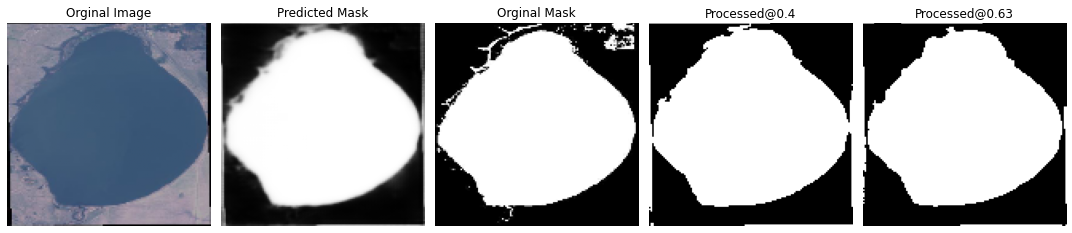

Epoch 19/100
72/72 [==============================] - 130s 2s/step - loss: 0.2911 - accuracy: 0.7277 - val_loss: 0.2471 - val_accuracy: 0.7348


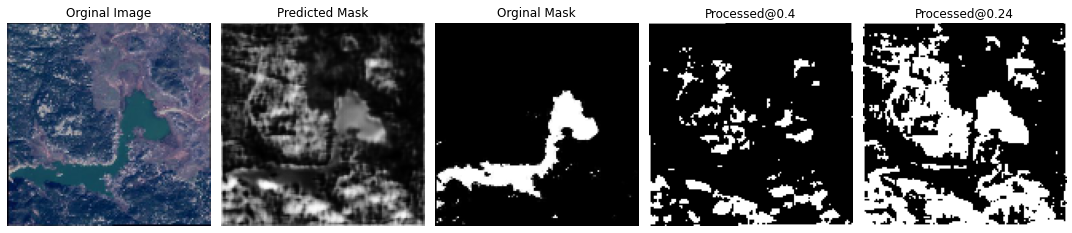

Epoch 20/100
72/72 [==============================] - 131s 2s/step - loss: 0.2801 - accuracy: 0.7310 - val_loss: 0.2521 - val_accuracy: 0.7360


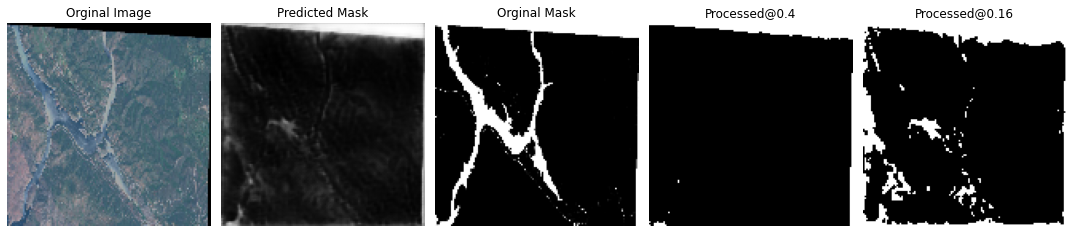

Epoch 21/100
72/72 [==============================] - 131s 2s/step - loss: 0.2738 - accuracy: 0.7331 - val_loss: 0.2399 - val_accuracy: 0.7400


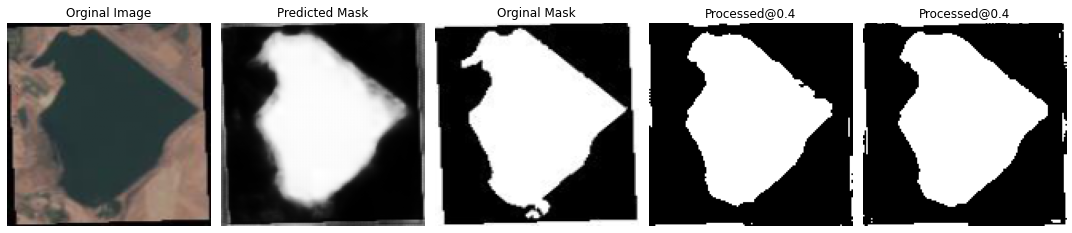

Epoch 22/100
72/72 [==============================] - 132s 2s/step - loss: 0.2710 - accuracy: 0.7342 - val_loss: 0.2331 - val_accuracy: 0.7399


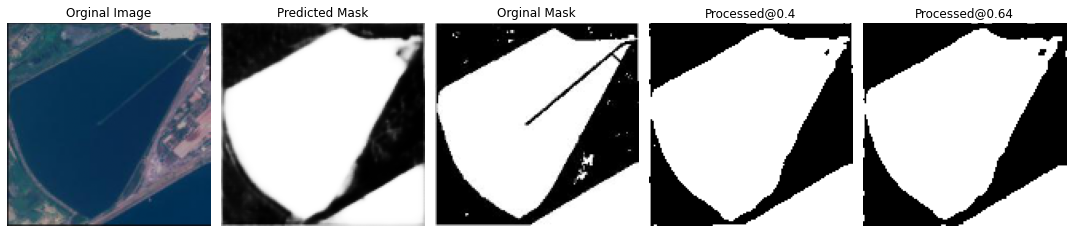

Epoch 23/100
72/72 [==============================] - 131s 2s/step - loss: 0.2672 - accuracy: 0.7367 - val_loss: 0.2517 - val_accuracy: 0.7349


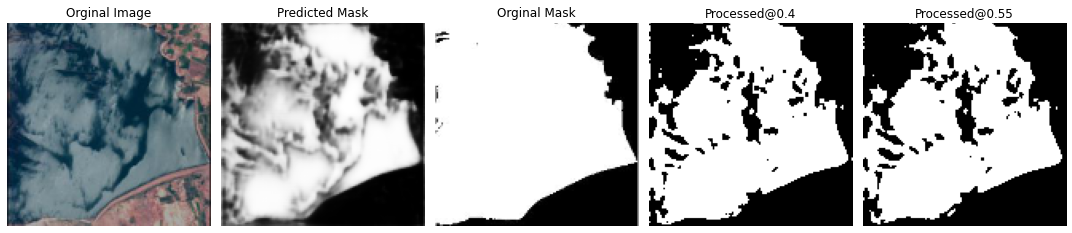

Epoch 24/100
72/72 [==============================] - 130s 2s/step - loss: 0.2606 - accuracy: 0.7378 - val_loss: 0.2440 - val_accuracy: 0.7397


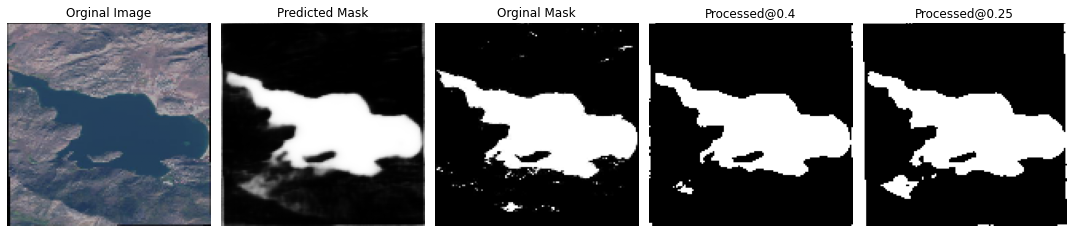

Epoch 25/100
72/72 [==============================] - 130s 2s/step - loss: 0.2609 - accuracy: 0.7378 - val_loss: 0.2463 - val_accuracy: 0.7361


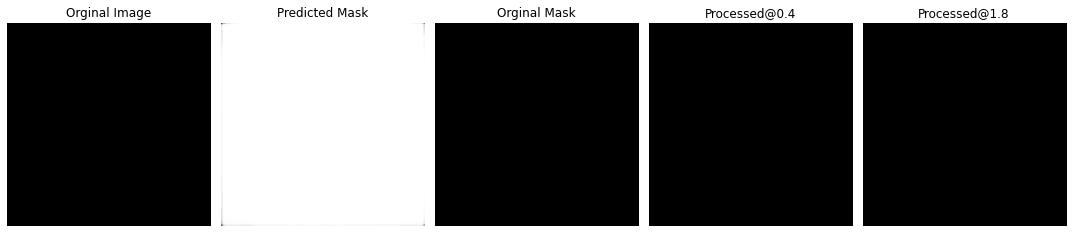

CPU times: user 3h 23min 53s, sys: 49.5 s, total: 3h 24min 43s
Wall time: 54min 53s


In [20]:
%%time
with tf.device("/GPU:0"):
  results = unet.fit(
      X, y,
      epochs=100,
      callbacks=callbacks,
      validation_split=0.1,
      batch_size=32
  )

You can decide what type of threshold you're willing to use. I kind of like loved the idea of using the adaptive threshold. Now, if you somehow find the best threshold value, then you can actually get the best masking, because the model is able to predict the mask correctly almost 99% of the time, but some of the regions are blurry and somehow, you will have to tackle them. My technique was to add this Adaptive Threshold your technique could be something else.

# **E.Testing**

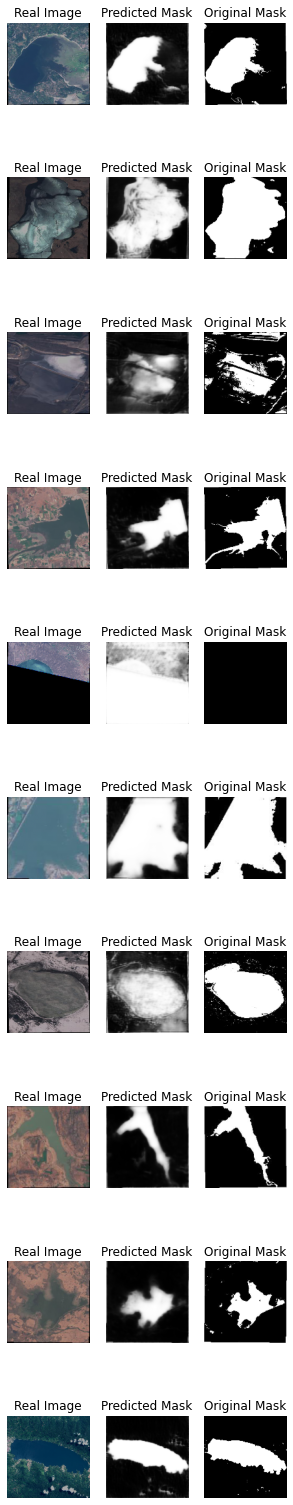

In [21]:
plt.figure(figsize=(5,28))
n=0
for i in range(1,31):
    plt.subplot(10,3,i)
    
    if n==0:
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = unet.predict(real_img).reshape(128,128)
        mask = masks[id].reshape(128,128)
        show_image(real_img[0], title="Real Image")
        n+=1
    elif n==1:
        show_image(pred_mask, title="Predicted Mask", cmap='gray')
        n+=1
    elif n==2:
        show_image(mask, title="Original Mask", cmap='gray')
        n=0

The **high clarity** that you are able to find in the **original mask** is probably because they have used a **threshold** and that makes it **highly clear**. But as our model is **producing that image**, it's pretty good that it's able to **produce images with mask**, even if they are a **little bit of blurry**. 

In [22]:
def process_single_image(image_path, SIZE):
    image = np.zeros(shape=(1, SIZE, SIZE, 3))

    img = img_to_array(load_img(image_path)).astype('float') / 255.
    img = cv.resize(img, (SIZE, SIZE), cv.INTER_AREA)
    image[0] = img

    return image

# F.Test on Pre and Post Flood Images

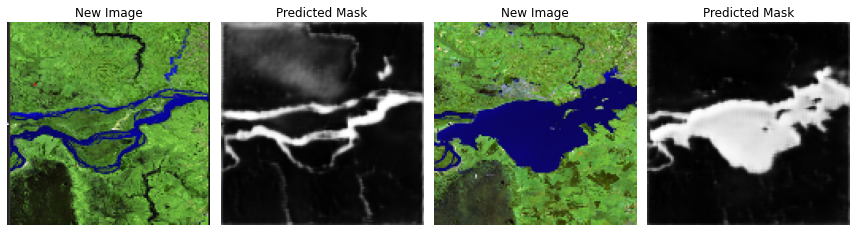

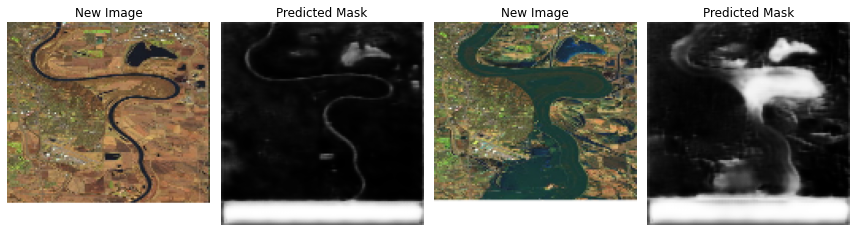

In [24]:
# Assuming process_single_image and unet.predict functions are already defined

new_SIZE = 128

# Get a list of all files in the folder

# Iterate over each file
for i in range(1,3):
    input_before="/kaggle/input/flood-detection-test/before/"+"{:03d}".format(i) +".png"
    input_after="/kaggle/input/flood-detection-test/after/" + "{:03d}".format(i) +".png" 

        # Process the image
    new_image_before = process_single_image(input_before, new_SIZE)
        
        # Predict mask for the new_image
    pred_mask_before = unet.predict(new_image_before).reshape(new_SIZE, new_SIZE)
        
         # Process the image
    new_image_after = process_single_image(input_after, new_SIZE)
        
        # Predict mask for the new_image
    pred_mask_after = unet.predict(new_image_after).reshape(new_SIZE, new_SIZE)
        
        
        
        # Visualize the new_image and the predicted mask
    plt.figure(figsize=(12, 28))  # Adjust the figure size as needed
        
        # Display the new_image
    plt.subplot(1, 4, 1)
    plt.imshow(new_image_before[0])  # Assuming new_image is a single image array
    plt.title("New Image")
    plt.axis('off')
        
        # Display the predicted mask
    plt.subplot(1, 4, 2)
    plt.imshow(pred_mask_before, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
        
    plt.subplot(1, 4, 3)
    plt.imshow(new_image_after[0])  # Assuming new_image is a single image array
    plt.title("New Image")
    plt.axis('off')
        
        # Display the predicted mask
    plt.subplot(1, 4, 4)
    plt.imshow(pred_mask_after, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
        
    plt.tight_layout()
    plt.show()


In [25]:
# Assuming process_single_image and unet.predict functions are already defined

new_SIZE = 128

# Iterate over each file
for i in range(1,3):
    input_before="/kaggle/input/flood-detection-test/before/"+"{:03d}".format(i) +".png"
    input_after="/kaggle/input/flood-detection-test/after/" + "{:03d}".format(i) +".png" 

    # Process the image before the event
    new_image_before = process_single_image(input_before, new_SIZE)
    
    # Predict mask for the image before the event
    pred_mask_before = unet.predict(new_image_before).reshape(new_SIZE, new_SIZE)
    
    # Process the image after the event
    new_image_after = process_single_image(input_after, new_SIZE)
    
    # Predict mask for the image after the event
    pred_mask_after = unet.predict(new_image_after).reshape(new_SIZE, new_SIZE)
    
    # Compute the absolute difference between the two masks
    mask_difference = abs(pred_mask_before - pred_mask_after)
    
    # Threshold the mask difference to identify significant changes
    threshold = 0.3  # You can adjust this threshold as needed
    significant_changes = mask_difference > threshold
    
    # Check if flood is present by determining if there are significant changes in the masks
    if significant_changes.any():
        print("Flood is detected in image", i)
    else:
        print("No flood detected in image", i)

Flood is detected in image 1
Flood is detected in image 2
